In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

def create_train_test_dirs(base_path):
    """Create train and test directories within the base path"""
    train_dir = os.path.join(base_path, 'train')
    test_dir = os.path.join(base_path, 'test')
    
    for dir_path in [train_dir, test_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
    
    return train_dir, test_dir

def split_data(base_path, split_ratio=0.7):
    """Split data from base path into train and test sets"""
    # Get all image files from base directory
    image_files = [f for f in os.listdir(base_path) 
                  if f.endswith(('.jpg', '.jpeg', '.png')) 
                  and os.path.isfile(os.path.join(base_path, f))]
    
    # Create train/test directories
    train_dir, test_dir = create_train_test_dirs(base_path)
    
    # Split the data
    train_files, test_files = train_test_split(image_files, 
                                             train_size=split_ratio, 
                                             random_state=42)
    
    # Move files to respective directories
    for file in train_files:
        src = os.path.join(base_path, file)
        dst = os.path.join(train_dir, file)
        shutil.move(src, dst)
    
    for file in test_files:
        src = os.path.join(base_path, file)
        dst = os.path.join(test_dir, file)
        shutil.move(src, dst)
    
    print(f"Total images: {len(image_files)}")
    print(f"Training images: {len(train_files)}")
    print(f"Testing images: {len(test_files)}")

if __name__ == "__main__":
    # Set your base path where images are located
    base_path = "dataset"
    
    # Split and move data
    split_data(base_path, split_ratio=0.7)

Total images: 102
Training images: 71
Testing images: 31


In [2]:
import os
import shutil
import random
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_path = os.path.join("dataset", "train")  # Path to training data
augmented_path = os.path.join("dataset", "train_augmented")

os.makedirs(augmented_path, exist_ok=True)

def get_next_image_number(train_path):
    """Find the highest image number in the existing files and return next number"""
    existing_files = [f for f in os.listdir(train_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    numbers = []
    
    for f in existing_files:
        try:
            # Extract number from filenames like 'IMG_102.jpg'
            num = int(f.split('_')[1].split('.')[0])
            numbers.append(num)
        except (IndexError, ValueError):
            continue

    return max(numbers) + 1 if numbers else 102  # Start numbering from 102 if no images exist

# Get list of training images
train_files = [f for f in os.listdir(train_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
next_image_number = get_next_image_number(train_path)

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Function to save augmented images
def save_augmented_image(image, number):
    filename = f'IMG_{number:03d}.jpg'
    cv2.imwrite(os.path.join(augmented_path, filename), image)

# Apply augmentation
num_augmented = 0
for file in train_files:
    img_path = os.path.join(train_path, file)
    image = cv2.imread(img_path)
    
    if image is None:
        continue  # Skip invalid images

    image = np.expand_dims(image, axis=0)  # Expand dimensions to match ImageDataGenerator input

    # Generate augmented images
    aug_iter = datagen.flow(image, batch_size=1)

    for i in range(5):  # Generate 5 augmented versions per image
        aug_image = next(aug_iter)[0].astype(np.uint8)
        save_augmented_image(aug_image, next_image_number)
        next_image_number += 1
        num_augmented += 1

print(f'Generated {num_augmented} augmented images in {augmented_path}')

# Move augmented images to training directory
for aug_file in os.listdir(augmented_path):
    src = os.path.join(augmented_path, aug_file)
    dst = os.path.join(train_path, aug_file)
    shutil.move(src, dst)

# Remove temporary augmented directory
os.rmdir(augmented_path)

print(f'Moved all augmented images to training directory')

Generated 355 augmented images in dataset/train_augmented
Moved all augmented images to training directory


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
import warnings  # Add this import
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.mps
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
# Fix for circular import - import specific components instead of full modules
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from tqdm import tqdm

In [4]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Attention Block for focusing on relevant features
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 8, kernel_size=1),
            nn.BatchNorm2d(in_channels // 8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 8, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

In [5]:
# ASPP Module for multi-scale feature extraction
class ASPPModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1)
        self.conv3_1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, dilation=1)
        self.conv3_6 = nn.Conv2d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.conv3_12 = nn.Conv2d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.bn = nn.BatchNorm2d(out_channels * 4)
        self.conv1x1 = nn.Conv2d(out_channels * 4, out_channels, 1)
        
    def forward(self, x):
        conv1 = self.conv1(x)
        conv3_1 = self.conv3_1(x)
        conv3_6 = self.conv3_6(x)
        conv3_12 = self.conv3_12(x)
        concat = torch.cat([conv1, conv3_1, conv3_6, conv3_12], dim=1)
        return self.conv1x1(self.bn(concat))

In [6]:
# Improved Segmentation Model
class ImprovedSegmentationModel(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        # Change the model initialization
        resnet = resnet50(weights='IMAGENET1K_V1')
        
        # Encoder
        self.encoder1 = nn.Sequential(*list(resnet.children())[:3])
        self.encoder2 = nn.Sequential(*list(resnet.children())[3:5])
        self.encoder3 = list(resnet.children())[5]
        self.encoder4 = list(resnet.children())[6]
        self.encoder5 = list(resnet.children())[7]
        
        # Attention blocks
        self.attention1 = AttentionBlock(256)
        self.attention2 = AttentionBlock(512)
        self.attention3 = AttentionBlock(1024)
        
        # ASPP module
        self.aspp = ASPPModule(2048, 256)
        
        # Decoder
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(1280, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(640, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(320, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, n_classes, kernel_size=1),
            nn.Sigmoid()
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Encoding
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        
        # Apply attention
        a2 = self.attention1(e2)
        a3 = self.attention2(e3)
        a4 = self.attention3(e4)
        
        # Apply ASPP
        aspp_out = self.aspp(e5)
        
        # Decoding with skip connections and attention
        d4 = self.decoder4(aspp_out)
        d4_concat = torch.cat([d4, a4], dim=1)
        
        d3 = self.decoder3(d4_concat)
        d3_concat = torch.cat([d3, a3], dim=1)
        
        d2 = self.decoder2(d3_concat)
        d2_concat = torch.cat([d2, a2], dim=1)
        
        d1 = self.decoder1(d2_concat)
        
        # Final convolution
        out = self.final_conv(d1)
        
        # Resize to input size
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=True)
        
        return out

In [7]:
# Replace CombinedLoss with DiceLoss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        intersection = torch.sum(pred * target)
        union = torch.sum(pred) + torch.sum(target)
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1.0 - dice

In [8]:
def calculate_metrics(pred, target):
    """Calculate Accuracy, IoU, Precision, Recall, F1 Score"""
    pred = (pred > 0.5).float()
    
    tp = torch.sum(pred * target)
    fp = torch.sum(pred * (1 - target))
    fn = torch.sum((1 - pred) * target)
    tn = torch.sum((1 - pred) * (1 - target))
    
    accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    iou = tp / (tp + fp + fn + 1e-6)
    
    return {
        'accuracy': accuracy.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'f1': f1.item(),
        'iou': iou.item()
    }

def calculate_iou(pred, target):
    """Calculate IoU score"""
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def calculate_dice_score(pred, target):
    """Calculate Dice score"""
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)

def get_training_config():
    return {
        'batch_size': 8,  # Increased batch size for faster processing
        'num_workers': 2,  # Added some workers for data loading
        'pin_memory': True,
        'prefetch_factor': 2,  # Add prefetching for better data loading
    }

def plot_metrics(metrics_history, output_folder):
    """Plot training and validation metrics"""
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'iou']
    plt.figure(figsize=(20, 15))
    
    for idx, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, idx)
        plt.plot(metrics_history['train'][metric], label=f'Train {metric}')
        plt.plot(metrics_history['val'][metric], label=f'Val {metric}')
        plt.title(f'{metric.capitalize()} over epochs')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'training_metrics.png'))
    plt.close()

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, output_folder):
    best_val_metrics = {'dice': 0.0, 'f1': 0.0}
    metrics_history = {
        'train': {'loss': [], 'accuracy': [], 'dice': [], 'precision': [], 'recall': [], 'f1': [], 'iou': []},
        'val': {'loss': [], 'accuracy': [], 'dice': [], 'precision': [], 'recall': [], 'f1': [], 'iou': []}
    }
    
    # Create progress logger with additional metrics
    metrics_file = os.path.join(output_folder, 'training_metrics.csv')
    with open(metrics_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_Accuracy', 'Train_Dice', 'Train_Precision', 
                        'Train_Recall', 'Train_F1', 'Train_IoU', 'Val_Loss', 'Val_Accuracy',
                        'Val_Dice', 'Val_Precision', 'Val_Recall', 'Val_F1', 'Val_IoU'])
    
    # Enable cuDNN autotuner
    torch.backends.cudnn.benchmark = True
    
    for epoch in range(num_epochs):
        model.train()
        train_metrics = {'loss': 0, 'accuracy': 0, 'dice': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'iou': 0}
        
        # Modified progress bar with all metrics
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (images, masks) in enumerate(progress_bar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Calculate all metrics for this batch
            dice_score = 1 - loss.item()
            batch_metrics = calculate_metrics(outputs, masks)
            
            # Update metrics
            train_metrics['loss'] += loss.item()
            train_metrics['accuracy'] += batch_metrics['accuracy']
            train_metrics['dice'] += dice_score
            train_metrics['precision'] += batch_metrics['precision']
            train_metrics['recall'] += batch_metrics['recall']
            train_metrics['f1'] += batch_metrics['f1']
            train_metrics['iou'] += batch_metrics['iou']
            
            loss.backward()
            optimizer.step()
            
            # Update progress bar with all metrics
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'accuracy': f"{batch_metrics['accuracy']:.4f}",
                'dice': f"{dice_score:.4f}",
                'prec': f"{batch_metrics['precision']:.4f}",
                'rec': f"{batch_metrics['recall']:.4f}",
                'f1': f"{batch_metrics['f1']:.4f}",
                'iou': f"{batch_metrics['iou']:.4f}"
            })
        
        # Calculate average training metrics
        num_batches = len(train_loader)
        for k in train_metrics:
            train_metrics[k] /= num_batches
        
        # Validation phase
        model.eval()
        val_metrics = {'loss': 0, 'accuracy': 0, 'dice': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'iou': 0}
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # Calculate metrics
                dice_score = 1 - loss.item()
                batch_metrics = calculate_metrics(outputs, masks)
                
                # Update metrics
                val_metrics['loss'] += loss.item()
                val_metrics['accuracy'] += batch_metrics['accuracy']
                val_metrics['dice'] += dice_score
                val_metrics['precision'] += batch_metrics['precision']
                val_metrics['recall'] += batch_metrics['recall']
                val_metrics['f1'] += batch_metrics['f1']
                val_metrics['iou'] += batch_metrics['iou']
        
        # Calculate average validation metrics
        num_val_batches = len(val_loader)
        for k in val_metrics:
            val_metrics[k] /= num_val_batches
        
        # Update learning rate
        scheduler.step(val_metrics['loss'])
        
        # Save metrics
        with open(metrics_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch + 1,
                f"{train_metrics['loss']:.4f}",
                f"{train_metrics['accuracy']:.4f}",
                f"{train_metrics['dice']:.4f}",
                f"{train_metrics['precision']:.4f}",
                f"{train_metrics['recall']:.4f}",
                f"{train_metrics['f1']:.4f}",
                f"{train_metrics['iou']:.4f}",
                f"{val_metrics['loss']:.4f}",
                f"{val_metrics['accuracy']:.4f}",
                f"{val_metrics['dice']:.4f}",
                f"{val_metrics['precision']:.4f}",
                f"{val_metrics['recall']:.4f}",
                f"{val_metrics['f1']:.4f}",
                f"{val_metrics['iou']:.4f}"
            ])
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train - Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.4f}, Dice: {train_metrics['dice']:.4f}, "
              f"F1: {train_metrics['f1']:.4f}, Precision: {train_metrics['precision']:.4f}, "
              f"Recall: {train_metrics['recall']:.4f}, IoU: {train_metrics['iou']:.4f}")
        print(f"Val - Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, Dice: {val_metrics['dice']:.4f}, "
              f"F1: {val_metrics['f1']:.4f}, Precision: {val_metrics['precision']:.4f}, "
              f"Recall: {val_metrics['recall']:.4f}, IoU: {val_metrics['iou']:.4f}")
        
        # Save best model
        if val_metrics['dice'] > best_val_metrics['dice']:
            best_val_metrics['dice'] = val_metrics['dice']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': val_metrics
            }, os.path.join(output_folder, 'best_model_dice.pth'))
            print(f"Saved new best model with dice score: {val_metrics['dice']:.4f}")
        
        # Store metrics history
        for phase in ['train', 'val']:
            metrics = train_metrics if phase == 'train' else val_metrics
            for k in metrics:
                metrics_history[phase][k].append(metrics[k])
    
    # After training completes, plot the metrics
    plot_metrics(metrics_history, output_folder)
    return metrics_history

def create_binary_masks(image_path):
    """Create binary masks using traditional CV method"""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([35, 40, 20])
    upper_bound = np.array([85, 255, 255])
    mask = cv2.inRange(image, lower_bound, upper_bound)
    return mask

In [10]:
# Dataset Class
class VegetationDataset(Dataset):
    def __init__(self, image_paths, masks=None, transform=None):
        self.image_paths = image_paths
        self.masks = masks
        self.transform = transform
        # Load images immediately instead of using multiprocessing
        self.loaded_images = {}
        self.loaded_masks = {}
        self._preload_images()
    
    def _preload_images(self):
        for idx, path in enumerate(self.image_paths):
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            self.loaded_images[idx] = image
            
            if self.masks is not None:
                self.loaded_masks[idx] = cv2.resize(self.masks[idx], (320, 320))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = self.loaded_images[idx]
        
        if self.transform:
            image = self.transform(image)
        
        if self.masks is not None:
            mask = self.loaded_masks[idx]
            mask = torch.FloatTensor(mask / 255.0)
            mask = mask.unsqueeze(0)
            return image, mask
        return image

In [11]:
def preprocess_image(image_path, model, device, transform):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]
    
    if transform:
        image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        mask_pred = model(image_tensor)
        mask_pred = mask_pred.squeeze().cpu().numpy()
        mask_pred = cv2.resize(mask_pred, (original_size[1], original_size[0]))
        mask_pred = (mask_pred > 0.5).astype(np.uint8) * 255
    
    return image, mask_pred

def segment_image(image, mask):
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return mask, segmented

def estimate_carbon_sequestration(mask, pixel_area=0.01):  # pixel_area in square meters
    """
    Calculate carbon sequestration based on vegetation area and biomass estimation
    Args:
        mask: Binary mask of vegetation
        pixel_area: Area represented by each pixel in square meters
    Returns:
        Dictionary containing carbon sequestration metrics
    """
    vegetation_area = np.sum(mask > 0) * pixel_area  # Total area in square meters
    
    # Biomass calculation constants
    biomass_factor = 0.5  # Average biomass per square meter for vegetation
    carbon_fraction = 0.47  # Standard carbon fraction in biomass
    co2_conversion = 3.67  # Conversion factor from C to CO2
    
    # Calculate metrics
    total_biomass = vegetation_area * biomass_factor  # kg
    carbon_content = total_biomass * carbon_fraction  # kg C
    co2_sequestered = carbon_content * co2_conversion  # kg CO2
    
    return {
        'vegetation_area_m2': vegetation_area,
        'biomass_kg': total_biomass,
        'carbon_content_kg': carbon_content,
        'co2_sequestered_kg': co2_sequestered
    }

In [12]:
def create_visualizations(all_visualizations, output_folder):
    """
    Create and save visualizations with enhanced carbon sequestration metrics
    """
    num_images = len(all_visualizations)
    fig = plt.figure(figsize=(20, 5 * num_images))
    
    for idx, (image, mask, segmented, metrics) in enumerate(all_visualizations):
        # Original image
        plt.subplot(num_images, 4, idx*4 + 1)
        plt.title(f"Original {idx+1}")
        plt.imshow(image)
        plt.axis('off')
        
        # Mask
        plt.subplot(num_images, 4, idx*4 + 2)
        plt.title(f"Vegetation Mask {idx+1}")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        
        # Segmented image
        plt.subplot(num_images, 4, idx*4 + 3)
        plt.title(f"Segmented Vegetation {idx+1}")
        plt.imshow(segmented)
        plt.axis('off')
        
        # Metrics text
        plt.subplot(num_images, 4, idx*4 + 4)
        plt.axis('off')
        plt.text(0.1, 0.7, 
                f"Area: {metrics['vegetation_area_m2']:.2f} m²\n"
                f"Biomass: {metrics['biomass_kg']:.2f} kg\n"
                f"Carbon: {metrics['carbon_content_kg']:.2f} kg C\n"
                f"CO₂ Seq: {metrics['co2_sequestered_kg']:.2f} kg CO₂",
                fontsize=10, fontfamily='monospace')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'all_results.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save individual results
    individual_dir = os.path.join(output_folder, 'individual_results')
    os.makedirs(individual_dir, exist_ok=True)
    
    for idx, (image, mask, segmented, metrics) in enumerate(all_visualizations):
        # Save metrics to CSV
        metrics_file = os.path.join(individual_dir, f'metrics_{idx+1}.csv')
        with open(metrics_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Metric', 'Value'])
            for key, value in metrics.items():
                writer.writerow([key, f'{value:.2f}'])
        
        # Save images
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"Original {idx+1}")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {idx+1}")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(segmented)
        plt.title(f"Segmented {idx+1}")
        plt.axis('off')
        
        plt.savefig(os.path.join(individual_dir, f'result_{idx+1}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()

In [13]:
def setup_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS backend for Mac GPU acceleration")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA GPU acceleration")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

def get_training_config():
    return {
        'batch_size': 8,  # Increased batch size for faster processing
        'num_workers': 2,  # Added some workers for data loading
        'pin_memory': True,
        'prefetch_factor': 2,  # Add prefetching for better data loading
    }

# Create data loaders with simplest configuration
def create_data_loaders(train_dataset, val_dataset, train_config):
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_config['batch_size'],
        shuffle=True,
        num_workers=0,
        pin_memory=train_config['pin_memory']
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=train_config['batch_size'],
        num_workers=0,
        pin_memory=train_config['pin_memory']
    )
    
    return train_loader, val_loader

def get_transform():
    return Compose([
        ToTensor(),
        Resize((320, 320), antialias=True),
        Normalize(mean=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225])
    ])

In [ ]:
def main():
    # Setup paths
    train_data_folder = 'dataset/train'  # Path to training data
    val_data_folder = 'dataset/test'     # Add missing val_data_folder
    output_folder = 'result'             # Add missing output_folder
    os.makedirs(output_folder, exist_ok=True)
    
    # Get device
    device = setup_device()
    print(f"Using device: {device}")
    
    train_config = get_training_config()
    
    # Data preparation with pre-split data
    print("Preparing dataset...")
    train_image_paths = []
    train_masks = []
    val_image_paths = []
    val_masks = []
    
    # Load training data
    for file_name in os.listdir(train_data_folder):
        if file_name.lower().endswith(('.jpg', '.png')):
            file_path = os.path.join(train_data_folder, file_name)
            mask = create_binary_masks(file_path)
            train_image_paths.append(file_path)
            train_masks.append(mask)
    
    # Load validation data
    for file_name in os.listdir(val_data_folder):
        if file_name.lower().endswith(('.jpg', '.png')):
            file_path = os.path.join(val_data_folder, file_name)
            mask = create_binary_masks(file_path)
            val_image_paths.append(file_path)
            val_masks.append(mask)
    
    # Optimized transform for M1
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((320, 320), antialias=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create optimized datasets
    train_dataset = VegetationDataset(train_image_paths, train_masks, transform=transform)
    val_dataset = VegetationDataset(val_image_paths, val_masks, transform=transform)
    
    # Create data loaders using the helper function
    train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, train_config)
    
    # Ensure model weights are on correct device
    model = ImprovedSegmentationModel()
    model = model.to(device)  # Simplified device transfer
    
    # Ensure model weights are on correct device
    for param in model.parameters():
        param.data = param.data.to(device)
    
    # Initialize training components with pure Dice Loss
    criterion = DiceLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.001,  # Slightly higher learning rate
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True,
        min_lr=1e-6
    )
    
    # Training
    print("Starting training...")
    # Train the model
    metrics_history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=100,
        device=device,
        output_folder=output_folder
    )
    
    print("Loading best model for inference...")
    
    # Load best model
    if device.type == 'mps':
        checkpoint = torch.load(os.path.join(output_folder, 'best_model_dice.pth'), map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
    else:
        checkpoint = torch.load(os.path.join(output_folder, 'best_model_dice.pth'))
        model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Process test images
    print("Processing test images...")
    test_images = []
    
    # Process all test images (remove the break condition)
    for file_name in os.listdir(val_data_folder):
        if file_name.lower().endswith(('.jpg', '.png')):
            file_path = os.path.join(val_data_folder, file_name)
            image, mask_pred = preprocess_image(file_path, model, device, transform)
            mask, segmented = segment_image(image, mask_pred)
            
            metrics = estimate_carbon_sequestration(mask)
            test_images.append((image, mask, segmented, metrics))
            
            print(f"\nFile: {file_name}")
            print(f"Vegetation Area: {metrics['vegetation_area_m2']:.2f} m²")
            print(f"Estimated Biomass: {metrics['biomass_kg']:.2f} kg")
            print(f"Carbon Content: {metrics['carbon_content_kg']:.2f} kg C")
            print(f"CO₂ Sequestered: {metrics['co2_sequestered_kg']:.2f} kg CO₂")
    
    # Create visualizations for all images
    if test_images:
        create_visualizations(test_images, output_folder)
        print(f"\nVisualization and metrics saved to {output_folder}")
    else:
        print("No test images were processed.")

if __name__ == "__main__":
    main()

Using MPS backend for Mac GPU acceleration
Using device: mps
Preparing dataset...
Starting training...


Epoch 1/100: 100%|██████████| 54/54 [00:59<00:00,  1.10s/it, loss=0.3953, accuracy=0.7813, dice=0.6047, prec=0.9998, rec=0.4313, f1=0.6026, iou=0.4313]



Epoch 1/100
Train - Loss: 0.4726, Accuracy: 0.9118, Dice: 0.5274, F1: 0.5628, Precision: 0.5503, Recall: 0.7561, IoU: 0.4469
Val - Loss: 0.3841, Accuracy: 0.9575, Dice: 0.6159, F1: 0.6319, Precision: 0.7953, Recall: 0.5731, IoU: 0.5050
Saved new best model with dice score: 0.6159


Epoch 2/100: 100%|██████████| 54/54 [01:02<00:00,  1.16s/it, loss=0.8935, accuracy=0.9340, dice=0.1065, prec=0.0611, rec=0.7366, f1=0.1129, iou=0.0598]



Epoch 2/100
Train - Loss: 0.3790, Accuracy: 0.9503, Dice: 0.6210, F1: 0.6370, Precision: 0.6376, Recall: 0.7662, IoU: 0.5149
Val - Loss: 0.3805, Accuracy: 0.9443, Dice: 0.6195, F1: 0.6294, Precision: 0.6035, Recall: 0.6717, IoU: 0.4896
Saved new best model with dice score: 0.6195


Epoch 3/100: 100%|██████████| 54/54 [01:09<00:00,  1.28s/it, loss=0.5432, accuracy=0.9356, dice=0.4568, prec=0.9045, rec=0.3111, f1=0.4630, iou=0.3012]



Epoch 3/100
Train - Loss: 0.3025, Accuracy: 0.9643, Dice: 0.6975, F1: 0.7083, Precision: 0.7481, Recall: 0.7494, IoU: 0.5869
Val - Loss: 0.4124, Accuracy: 0.9514, Dice: 0.5876, F1: 0.5936, Precision: 0.7526, Recall: 0.5712, IoU: 0.4711


Epoch 4/100: 100%|██████████| 54/54 [01:04<00:00,  1.20s/it, loss=0.7009, accuracy=0.9335, dice=0.2991, prec=0.2138, rec=0.5487, f1=0.3077, iou=0.1818]



Epoch 4/100
Train - Loss: 0.3263, Accuracy: 0.9630, Dice: 0.6737, F1: 0.6840, Precision: 0.6960, Recall: 0.7289, IoU: 0.5589
Val - Loss: 0.3290, Accuracy: 0.9538, Dice: 0.6710, F1: 0.6780, Precision: 0.6647, Recall: 0.6994, IoU: 0.5434
Saved new best model with dice score: 0.6710


Epoch 5/100: 100%|██████████| 54/54 [01:04<00:00,  1.20s/it, loss=0.9689, accuracy=0.9698, dice=0.0311, prec=0.0169, rec=0.9885, f1=0.0333, iou=0.0169]



Epoch 5/100
Train - Loss: 0.3678, Accuracy: 0.9610, Dice: 0.6322, F1: 0.6389, Precision: 0.6525, Recall: 0.7279, IoU: 0.5171
Val - Loss: 0.3386, Accuracy: 0.9475, Dice: 0.6614, F1: 0.6653, Precision: 0.6217, Recall: 0.7270, IoU: 0.5327


Epoch 6/100: 100%|██████████| 54/54 [01:06<00:00,  1.23s/it, loss=0.1106, accuracy=0.9570, dice=0.8894, prec=0.9421, rec=0.8444, f1=0.8906, iou=0.8027]



Epoch 6/100
Train - Loss: 0.3150, Accuracy: 0.9657, Dice: 0.6850, F1: 0.6914, Precision: 0.7142, Recall: 0.7385, IoU: 0.5726
Val - Loss: 0.3485, Accuracy: 0.9627, Dice: 0.6515, F1: 0.6562, Precision: 0.8505, Recall: 0.5857, IoU: 0.5358


Epoch 7/100: 100%|██████████| 54/54 [01:08<00:00,  1.26s/it, loss=0.9904, accuracy=0.9787, dice=0.0096, prec=0.0067, rec=0.0472, f1=0.0117, iou=0.0059]



Epoch 7/100
Train - Loss: 0.3451, Accuracy: 0.9638, Dice: 0.6549, F1: 0.6600, Precision: 0.6847, Recall: 0.7182, IoU: 0.5404
Val - Loss: 0.3283, Accuracy: 0.9509, Dice: 0.6717, F1: 0.6761, Precision: 0.6450, Recall: 0.7127, IoU: 0.5401
Saved new best model with dice score: 0.6717


Epoch 8/100: 100%|██████████| 54/54 [01:12<00:00,  1.35s/it, loss=0.1992, accuracy=0.9524, dice=0.8008, prec=0.9129, rec=0.7197, f1=0.8049, iou=0.6735]



Epoch 8/100
Train - Loss: 0.3150, Accuracy: 0.9664, Dice: 0.6850, F1: 0.6902, Precision: 0.7283, Recall: 0.7236, IoU: 0.5664
Val - Loss: 0.3602, Accuracy: 0.9471, Dice: 0.6398, F1: 0.6439, Precision: 0.6852, Recall: 0.6633, IoU: 0.5087


Epoch 9/100: 100%|██████████| 54/54 [01:12<00:00,  1.34s/it, loss=0.9123, accuracy=0.9864, dice=0.0877, prec=0.0508, rec=0.5458, f1=0.0930, iou=0.0488]



Epoch 9/100
Train - Loss: 0.2621, Accuracy: 0.9732, Dice: 0.7379, F1: 0.7429, Precision: 0.7849, Recall: 0.7481, IoU: 0.6265
Val - Loss: 0.3281, Accuracy: 0.9587, Dice: 0.6719, F1: 0.6745, Precision: 0.7268, Recall: 0.6609, IoU: 0.5476
Saved new best model with dice score: 0.6719


Epoch 10/100: 100%|██████████| 54/54 [01:13<00:00,  1.36s/it, loss=0.8248, accuracy=0.9719, dice=0.1752, prec=0.1110, rec=0.3939, f1=0.1732, iou=0.0948]



Epoch 10/100
Train - Loss: 0.2647, Accuracy: 0.9723, Dice: 0.7353, F1: 0.7404, Precision: 0.7775, Recall: 0.7314, IoU: 0.6181
Val - Loss: 0.3166, Accuracy: 0.9617, Dice: 0.6834, F1: 0.6899, Precision: 0.7684, Recall: 0.6430, IoU: 0.5618
Saved new best model with dice score: 0.6834


Epoch 11/100: 100%|██████████| 54/54 [01:17<00:00,  1.43s/it, loss=0.7074, accuracy=0.9794, dice=0.2926, prec=0.4730, rec=0.2156, f1=0.2962, iou=0.1739]



Epoch 11/100
Train - Loss: 0.2636, Accuracy: 0.9724, Dice: 0.7364, F1: 0.7415, Precision: 0.7804, Recall: 0.7365, IoU: 0.6216
Val - Loss: 0.3513, Accuracy: 0.9610, Dice: 0.6487, F1: 0.6534, Precision: 0.8544, Recall: 0.5861, IoU: 0.5286


Epoch 12/100: 100%|██████████| 54/54 [01:13<00:00,  1.37s/it, loss=0.4653, accuracy=0.9421, dice=0.5347, prec=0.3763, rec=0.9440, f1=0.5381, iou=0.3681]



Epoch 12/100
Train - Loss: 0.2621, Accuracy: 0.9728, Dice: 0.7379, F1: 0.7426, Precision: 0.7687, Recall: 0.7507, IoU: 0.6208
Val - Loss: 0.3107, Accuracy: 0.9643, Dice: 0.6893, F1: 0.6927, Precision: 0.7886, Recall: 0.6490, IoU: 0.5720
Saved new best model with dice score: 0.6893


Epoch 13/100: 100%|██████████| 54/54 [01:13<00:00,  1.36s/it, loss=0.8542, accuracy=0.9650, dice=0.1458, prec=0.1092, rec=0.2135, f1=0.1445, iou=0.0779]



Epoch 13/100
Train - Loss: 0.2814, Accuracy: 0.9716, Dice: 0.7186, F1: 0.7230, Precision: 0.7437, Recall: 0.7499, IoU: 0.6068
Val - Loss: 0.3513, Accuracy: 0.9604, Dice: 0.6487, F1: 0.6547, Precision: 0.8371, Recall: 0.5601, IoU: 0.5220


Epoch 14/100: 100%|██████████| 54/54 [01:13<00:00,  1.36s/it, loss=0.7813, accuracy=0.9683, dice=0.2187, prec=0.1443, rec=0.5327, f1=0.2271, iou=0.1281]



Epoch 14/100
Train - Loss: 0.2673, Accuracy: 0.9730, Dice: 0.7327, F1: 0.7376, Precision: 0.7703, Recall: 0.7417, IoU: 0.6164
Val - Loss: 0.3091, Accuracy: 0.9623, Dice: 0.6909, F1: 0.6957, Precision: 0.7616, Recall: 0.6740, IoU: 0.5724
Saved new best model with dice score: 0.6909


Epoch 15/100: 100%|██████████| 54/54 [01:12<00:00,  1.34s/it, loss=0.4072, accuracy=0.8795, dice=0.5928, prec=0.9962, rec=0.4211, f1=0.5919, iou=0.4204]



Epoch 15/100
Train - Loss: 0.2907, Accuracy: 0.9682, Dice: 0.7093, F1: 0.7136, Precision: 0.7336, Recall: 0.7503, IoU: 0.5935
Val - Loss: 0.3675, Accuracy: 0.9621, Dice: 0.6325, F1: 0.6356, Precision: 0.8787, Recall: 0.5493, IoU: 0.5153


Epoch 16/100: 100%|██████████| 54/54 [01:15<00:00,  1.40s/it, loss=0.6564, accuracy=0.9809, dice=0.3436, prec=0.2330, rec=0.6797, f1=0.3471, iou=0.2100]



Epoch 16/100
Train - Loss: 0.2449, Accuracy: 0.9736, Dice: 0.7551, F1: 0.7592, Precision: 0.7915, Recall: 0.7506, IoU: 0.6384
Val - Loss: 0.3189, Accuracy: 0.9648, Dice: 0.6811, F1: 0.6860, Precision: 0.8270, Recall: 0.6354, IoU: 0.5670


Epoch 17/100: 100%|██████████| 54/54 [01:17<00:00,  1.43s/it, loss=0.6279, accuracy=0.9461, dice=0.3721, prec=0.9102, rec=0.2360, f1=0.3748, iou=0.2306]



Epoch 17/100
Train - Loss: 0.2748, Accuracy: 0.9734, Dice: 0.7252, F1: 0.7302, Precision: 0.7735, Recall: 0.7333, IoU: 0.6107
Val - Loss: 0.3232, Accuracy: 0.9664, Dice: 0.6768, F1: 0.6835, Precision: 0.8665, Recall: 0.6138, IoU: 0.5665


Epoch 18/100: 100%|██████████| 54/54 [01:16<00:00,  1.42s/it, loss=0.8422, accuracy=0.9396, dice=0.1578, prec=0.1389, rec=0.1858, f1=0.1589, iou=0.0863]



Epoch 18/100
Train - Loss: 0.2733, Accuracy: 0.9738, Dice: 0.7267, F1: 0.7313, Precision: 0.7534, Recall: 0.7452, IoU: 0.6135
Val - Loss: 0.3039, Accuracy: 0.9613, Dice: 0.6961, F1: 0.7027, Precision: 0.7243, Recall: 0.6999, IoU: 0.5779
Saved new best model with dice score: 0.6961


Epoch 19/100: 100%|██████████| 54/54 [01:15<00:00,  1.40s/it, loss=0.1801, accuracy=0.9588, dice=0.8199, prec=0.9370, rec=0.7383, f1=0.8259, iou=0.7034]



Epoch 19/100
Train - Loss: 0.2574, Accuracy: 0.9756, Dice: 0.7426, F1: 0.7478, Precision: 0.7890, Recall: 0.7362, IoU: 0.6293
Val - Loss: 0.3281, Accuracy: 0.9618, Dice: 0.6719, F1: 0.6761, Precision: 0.8216, Recall: 0.6278, IoU: 0.5512


Epoch 20/100: 100%|██████████| 54/54 [01:15<00:00,  1.39s/it, loss=0.8993, accuracy=0.9177, dice=0.1007, prec=0.1369, rec=0.0708, f1=0.0933, iou=0.0490]



Epoch 20/100
Train - Loss: 0.2846, Accuracy: 0.9731, Dice: 0.7154, F1: 0.7199, Precision: 0.7349, Recall: 0.7433, IoU: 0.6068
Val - Loss: 0.3054, Accuracy: 0.9650, Dice: 0.6946, F1: 0.6998, Precision: 0.7944, Recall: 0.6594, IoU: 0.5791


Epoch 21/100: 100%|██████████| 54/54 [01:14<00:00,  1.38s/it, loss=0.0781, accuracy=0.9740, dice=0.9219, prec=0.8939, rec=0.9567, f1=0.9242, iou=0.8591]



Epoch 21/100
Train - Loss: 0.2403, Accuracy: 0.9774, Dice: 0.7597, F1: 0.7646, Precision: 0.7991, Recall: 0.7525, IoU: 0.6498
Val - Loss: 0.3191, Accuracy: 0.9667, Dice: 0.6809, F1: 0.6852, Precision: 0.8739, Recall: 0.6170, IoU: 0.5695


Epoch 22/100: 100%|██████████| 54/54 [01:12<00:00,  1.35s/it, loss=0.1092, accuracy=0.9636, dice=0.8908, prec=0.9707, rec=0.8281, f1=0.8937, iou=0.8079]



Epoch 22/100
Train - Loss: 0.2691, Accuracy: 0.9710, Dice: 0.7309, F1: 0.7359, Precision: 0.7485, Recall: 0.7693, IoU: 0.6190
Val - Loss: 0.3232, Accuracy: 0.9668, Dice: 0.6768, F1: 0.6814, Precision: 0.8863, Recall: 0.6129, IoU: 0.5674


Epoch 23/100: 100%|██████████| 54/54 [01:12<00:00,  1.34s/it, loss=0.7698, accuracy=0.9648, dice=0.2302, prec=0.2057, rec=0.2960, f1=0.2427, iou=0.1381]



Epoch 23/100
Train - Loss: 0.2441, Accuracy: 0.9765, Dice: 0.7559, F1: 0.7615, Precision: 0.7850, Recall: 0.7543, IoU: 0.6448
Val - Loss: 0.3074, Accuracy: 0.9673, Dice: 0.6926, F1: 0.6982, Precision: 0.8578, Recall: 0.6382, IoU: 0.5825


Epoch 24/100: 100%|██████████| 54/54 [01:20<00:00,  1.50s/it, loss=1.0000, accuracy=0.9748, dice=0.0000, prec=0.0000, rec=0.0000, f1=0.0000, iou=0.0000]



Epoch 24/100
Train - Loss: 0.2476, Accuracy: 0.9774, Dice: 0.7524, F1: 0.7579, Precision: 0.7694, Recall: 0.7624, IoU: 0.6444
Val - Loss: 0.2888, Accuracy: 0.9649, Dice: 0.7112, F1: 0.7159, Precision: 0.7461, Recall: 0.6975, IoU: 0.5964
Saved new best model with dice score: 0.7112


Epoch 25/100: 100%|██████████| 54/54 [01:29<00:00,  1.65s/it, loss=0.4675, accuracy=0.9917, dice=0.5325, prec=0.4319, rec=0.8059, f1=0.5624, iou=0.3912]



Epoch 25/100
Train - Loss: 0.2567, Accuracy: 0.9772, Dice: 0.7433, F1: 0.7505, Precision: 0.7728, Recall: 0.7513, IoU: 0.6325
Val - Loss: 0.3154, Accuracy: 0.9673, Dice: 0.6846, F1: 0.6913, Precision: 0.8828, Recall: 0.6164, IoU: 0.5746


Epoch 26/100: 100%|██████████| 54/54 [01:27<00:00,  1.61s/it, loss=0.4804, accuracy=0.9829, dice=0.5196, prec=0.5915, rec=0.4918, f1=0.5371, iou=0.3671]



Epoch 26/100
Train - Loss: 0.2529, Accuracy: 0.9775, Dice: 0.7471, F1: 0.7532, Precision: 0.7690, Recall: 0.7557, IoU: 0.6401
Val - Loss: 0.3080, Accuracy: 0.9663, Dice: 0.6920, F1: 0.7107, Precision: 0.7782, Recall: 0.6748, IoU: 0.5932


Epoch 27/100: 100%|██████████| 54/54 [01:25<00:00,  1.59s/it, loss=0.9844, accuracy=0.9785, dice=0.0156, prec=0.0076, rec=0.1011, f1=0.0142, iou=0.0072]



Epoch 27/100
Train - Loss: 0.2711, Accuracy: 0.9757, Dice: 0.7289, F1: 0.7335, Precision: 0.7527, Recall: 0.7518, IoU: 0.6220
Val - Loss: 0.2982, Accuracy: 0.9658, Dice: 0.7018, F1: 0.7078, Precision: 0.7923, Recall: 0.6642, IoU: 0.5879


Epoch 28/100: 100%|██████████| 54/54 [01:35<00:00,  1.76s/it, loss=0.6807, accuracy=0.9846, dice=0.3193, prec=0.2171, rec=0.6977, f1=0.3311, iou=0.1984]



Epoch 28/100
Train - Loss: 0.2457, Accuracy: 0.9783, Dice: 0.7543, F1: 0.7601, Precision: 0.7859, Recall: 0.7550, IoU: 0.6432
Val - Loss: 0.3039, Accuracy: 0.9651, Dice: 0.6961, F1: 0.7012, Precision: 0.8144, Recall: 0.6619, IoU: 0.5823


Epoch 29/100: 100%|██████████| 54/54 [01:25<00:00,  1.58s/it, loss=0.4674, accuracy=0.9833, dice=0.5326, prec=0.5418, rec=0.5417, f1=0.5418, iou=0.3715]



Epoch 29/100
Train - Loss: 0.2344, Accuracy: 0.9787, Dice: 0.7656, F1: 0.7717, Precision: 0.7891, Recall: 0.7710, IoU: 0.6607
Val - Loss: 0.2928, Accuracy: 0.9677, Dice: 0.7072, F1: 0.7127, Precision: 0.8163, Recall: 0.6669, IoU: 0.5969


Epoch 30/100: 100%|██████████| 54/54 [01:49<00:00,  2.04s/it, loss=0.6028, accuracy=0.9940, dice=0.3972, prec=0.2693, rec=0.9189, f1=0.4165, iou=0.2630]



Epoch 30/100
Train - Loss: 0.2190, Accuracy: 0.9792, Dice: 0.7810, F1: 0.7875, Precision: 0.8039, Recall: 0.7947, IoU: 0.6808
Val - Loss: 0.2876, Accuracy: 0.9675, Dice: 0.7124, F1: 0.7192, Precision: 0.7905, Recall: 0.6830, IoU: 0.6027
Saved new best model with dice score: 0.7124


Epoch 31/100: 100%|██████████| 54/54 [01:38<00:00,  1.83s/it, loss=0.5316, accuracy=0.9411, dice=0.4684, prec=0.4491, rec=0.5137, f1=0.4792, iou=0.3151]



Epoch 31/100
Train - Loss: 0.2602, Accuracy: 0.9772, Dice: 0.7398, F1: 0.7460, Precision: 0.7651, Recall: 0.7548, IoU: 0.6346
Val - Loss: 0.3050, Accuracy: 0.9681, Dice: 0.6950, F1: 0.7016, Precision: 0.8651, Recall: 0.6419, IoU: 0.5879


Epoch 32/100: 100%|██████████| 54/54 [01:39<00:00,  1.83s/it, loss=0.5761, accuracy=0.9789, dice=0.4239, prec=0.4019, rec=0.4840, f1=0.4391, iou=0.2813]



Epoch 32/100
Train - Loss: 0.2235, Accuracy: 0.9799, Dice: 0.7765, F1: 0.7838, Precision: 0.8049, Recall: 0.7716, IoU: 0.6716
Val - Loss: 0.3061, Accuracy: 0.9684, Dice: 0.6939, F1: 0.7002, Precision: 0.8730, Recall: 0.6368, IoU: 0.5870


Epoch 33/100: 100%|██████████| 54/54 [01:35<00:00,  1.76s/it, loss=0.4078, accuracy=0.9084, dice=0.5922, prec=0.9488, rec=0.4351, f1=0.5967, iou=0.4252]



Epoch 33/100
Train - Loss: 0.2183, Accuracy: 0.9788, Dice: 0.7817, F1: 0.7894, Precision: 0.8108, Recall: 0.7807, IoU: 0.6761
Val - Loss: 0.3158, Accuracy: 0.9686, Dice: 0.6842, F1: 0.6910, Precision: 0.8978, Recall: 0.6166, IoU: 0.5788


Epoch 34/100: 100%|██████████| 54/54 [01:29<00:00,  1.66s/it, loss=0.7450, accuracy=0.9246, dice=0.2550, prec=0.2665, rec=0.2490, f1=0.2575, iou=0.1477]



Epoch 34/100
Train - Loss: 0.2468, Accuracy: 0.9779, Dice: 0.7532, F1: 0.7599, Precision: 0.7682, Recall: 0.7691, IoU: 0.6502
Val - Loss: 0.2942, Accuracy: 0.9653, Dice: 0.7058, F1: 0.7124, Precision: 0.7979, Recall: 0.6833, IoU: 0.5933


Epoch 35/100: 100%|██████████| 54/54 [01:22<00:00,  1.52s/it, loss=0.0589, accuracy=0.9826, dice=0.9411, prec=0.9886, rec=0.9061, f1=0.9456, iou=0.8968]



Epoch 35/100
Train - Loss: 0.2339, Accuracy: 0.9796, Dice: 0.7661, F1: 0.7737, Precision: 0.7993, Recall: 0.7638, IoU: 0.6619
Val - Loss: 0.3042, Accuracy: 0.9681, Dice: 0.6958, F1: 0.7031, Precision: 0.8658, Recall: 0.6340, IoU: 0.5877


Epoch 36/100: 100%|██████████| 54/54 [01:30<00:00,  1.67s/it, loss=0.1176, accuracy=0.9652, dice=0.8824, prec=0.9316, rec=0.8543, f1=0.8913, iou=0.8039]



Epoch 36/100
Train - Loss: 0.2264, Accuracy: 0.9776, Dice: 0.7736, F1: 0.7810, Precision: 0.8072, Recall: 0.7650, IoU: 0.6680
Val - Loss: 0.3070, Accuracy: 0.9684, Dice: 0.6930, F1: 0.6991, Precision: 0.8814, Recall: 0.6216, IoU: 0.5843


Epoch 37/100: 100%|██████████| 54/54 [01:29<00:00,  1.67s/it, loss=0.7452, accuracy=0.9796, dice=0.2548, prec=0.2378, rec=0.2971, f1=0.2641, iou=0.1522]



Epoch 37/100
Train - Loss: 0.2302, Accuracy: 0.9801, Dice: 0.7698, F1: 0.7770, Precision: 0.8019, Recall: 0.7666, IoU: 0.6641
Val - Loss: 0.2874, Accuracy: 0.9684, Dice: 0.7126, F1: 0.7191, Precision: 0.8130, Recall: 0.6797, IoU: 0.6050
Saved new best model with dice score: 0.7126


Epoch 38/100: 100%|██████████| 54/54 [01:29<00:00,  1.66s/it, loss=0.0721, accuracy=0.9637, dice=0.9279, prec=0.9831, rec=0.8860, f1=0.9320, iou=0.8727]



Epoch 38/100
Train - Loss: 0.2114, Accuracy: 0.9801, Dice: 0.7886, F1: 0.7957, Precision: 0.8232, Recall: 0.7808, IoU: 0.6863
Val - Loss: 0.3137, Accuracy: 0.9688, Dice: 0.6863, F1: 0.6922, Precision: 0.9015, Recall: 0.6151, IoU: 0.5805


Epoch 39/100: 100%|██████████| 54/54 [01:32<00:00,  1.72s/it, loss=0.1171, accuracy=0.9596, dice=0.8829, prec=0.8293, rec=0.9503, f1=0.8857, iou=0.7948]



Epoch 39/100
Train - Loss: 0.2087, Accuracy: 0.9808, Dice: 0.7913, F1: 0.7992, Precision: 0.8086, Recall: 0.8017, IoU: 0.6928
Val - Loss: 0.2904, Accuracy: 0.9692, Dice: 0.7096, F1: 0.7161, Precision: 0.8413, Recall: 0.6613, IoU: 0.6032


Epoch 40/100: 100%|██████████| 54/54 [01:22<00:00,  1.52s/it, loss=0.0589, accuracy=0.9653, dice=0.9411, prec=0.9897, rec=0.9091, f1=0.9477, iou=0.9006]



Epoch 40/100
Train - Loss: 0.2117, Accuracy: 0.9804, Dice: 0.7883, F1: 0.7952, Precision: 0.8202, Recall: 0.7838, IoU: 0.6881
Val - Loss: 0.3255, Accuracy: 0.9679, Dice: 0.6745, F1: 0.6814, Precision: 0.9159, Recall: 0.5924, IoU: 0.5675


Epoch 41/100: 100%|██████████| 54/54 [01:21<00:00,  1.51s/it, loss=0.7407, accuracy=0.9899, dice=0.2593, prec=0.2540, rec=0.3017, f1=0.2758, iou=0.1599]



Epoch 41/100
Train - Loss: 0.2244, Accuracy: 0.9810, Dice: 0.7756, F1: 0.7840, Precision: 0.7972, Recall: 0.7803, IoU: 0.6749
Val - Loss: 0.2828, Accuracy: 0.9681, Dice: 0.7172, F1: 0.7242, Precision: 0.7931, Recall: 0.6961, IoU: 0.6101
Saved new best model with dice score: 0.7172


Epoch 42/100: 100%|██████████| 54/54 [01:18<00:00,  1.45s/it, loss=0.1371, accuracy=0.9584, dice=0.8629, prec=0.8035, rec=0.9411, f1=0.8669, iou=0.7651]



Epoch 42/100
Train - Loss: 0.2193, Accuracy: 0.9803, Dice: 0.7807, F1: 0.7884, Precision: 0.7982, Recall: 0.7916, IoU: 0.6812
Val - Loss: 0.2892, Accuracy: 0.9683, Dice: 0.7108, F1: 0.7182, Precision: 0.8192, Recall: 0.6745, IoU: 0.6042


Epoch 43/100: 100%|██████████| 54/54 [01:19<00:00,  1.47s/it, loss=0.4226, accuracy=0.9933, dice=0.5774, prec=0.4295, rec=0.9658, f1=0.5945, iou=0.4230]



Epoch 43/100
Train - Loss: 0.2346, Accuracy: 0.9811, Dice: 0.7654, F1: 0.7742, Precision: 0.7865, Recall: 0.7722, IoU: 0.6632
Val - Loss: 0.2792, Accuracy: 0.9680, Dice: 0.7208, F1: 0.7270, Precision: 0.7785, Recall: 0.6996, IoU: 0.6116
Saved new best model with dice score: 0.7208


Epoch 44/100: 100%|██████████| 54/54 [01:24<00:00,  1.56s/it, loss=0.6491, accuracy=0.9482, dice=0.3509, prec=0.3207, rec=0.4057, f1=0.3582, iou=0.2182]



Epoch 44/100
Train - Loss: 0.2520, Accuracy: 0.9797, Dice: 0.7480, F1: 0.7572, Precision: 0.7786, Recall: 0.7562, IoU: 0.6441
Val - Loss: 0.2911, Accuracy: 0.9664, Dice: 0.7089, F1: 0.7147, Precision: 0.7979, Recall: 0.6856, IoU: 0.5983


Epoch 45/100: 100%|██████████| 54/54 [01:16<00:00,  1.42s/it, loss=1.0000, accuracy=0.9714, dice=0.0000, prec=0.0000, rec=0.0000, f1=0.0000, iou=0.0000]



Epoch 45/100
Train - Loss: 0.2078, Accuracy: 0.9807, Dice: 0.7922, F1: 0.7990, Precision: 0.8119, Recall: 0.7938, IoU: 0.6945
Val - Loss: 0.2878, Accuracy: 0.9701, Dice: 0.7122, F1: 0.7190, Precision: 0.8480, Recall: 0.6632, IoU: 0.6079


Epoch 46/100: 100%|██████████| 54/54 [01:14<00:00,  1.38s/it, loss=0.6778, accuracy=0.9839, dice=0.3222, prec=0.3664, rec=0.2916, f1=0.3247, iou=0.1938]



Epoch 46/100
Train - Loss: 0.2247, Accuracy: 0.9810, Dice: 0.7753, F1: 0.7832, Precision: 0.8054, Recall: 0.7782, IoU: 0.6714
Val - Loss: 0.2917, Accuracy: 0.9699, Dice: 0.7083, F1: 0.7152, Precision: 0.8635, Recall: 0.6501, IoU: 0.6033


Epoch 47/100: 100%|██████████| 54/54 [01:13<00:00,  1.36s/it, loss=0.7123, accuracy=0.9835, dice=0.2877, prec=0.4550, rec=0.2091, f1=0.2865, iou=0.1672]



Epoch 47/100
Train - Loss: 0.2250, Accuracy: 0.9809, Dice: 0.7750, F1: 0.7828, Precision: 0.8128, Recall: 0.7725, IoU: 0.6740
Val - Loss: 0.2847, Accuracy: 0.9683, Dice: 0.7153, F1: 0.7216, Precision: 0.8114, Recall: 0.6796, IoU: 0.6065


Epoch 48/100: 100%|██████████| 54/54 [01:14<00:00,  1.38s/it, loss=0.5682, accuracy=0.9600, dice=0.4318, prec=0.6898, rec=0.3185, f1=0.4358, iou=0.2786]



Epoch 48/100
Train - Loss: 0.2366, Accuracy: 0.9805, Dice: 0.7634, F1: 0.7710, Precision: 0.7813, Recall: 0.7751, IoU: 0.6654
Val - Loss: 0.2942, Accuracy: 0.9682, Dice: 0.7058, F1: 0.7118, Precision: 0.8416, Recall: 0.6665, IoU: 0.5985


Epoch 49/100: 100%|██████████| 54/54 [01:13<00:00,  1.35s/it, loss=0.0573, accuracy=0.9787, dice=0.9427, prec=0.9257, rec=0.9725, f1=0.9485, iou=0.9021]



Epoch 49/100
Train - Loss: 0.2182, Accuracy: 0.9813, Dice: 0.7818, F1: 0.7903, Precision: 0.8129, Recall: 0.7795, IoU: 0.6802
Val - Loss: 0.2913, Accuracy: 0.9700, Dice: 0.7087, F1: 0.7155, Precision: 0.8653, Recall: 0.6558, IoU: 0.6046


Epoch 50/100: 100%|██████████| 54/54 [01:12<00:00,  1.34s/it, loss=0.8193, accuracy=0.9096, dice=0.1807, prec=0.1061, rec=0.7022, f1=0.1843, iou=0.1015]



Epoch 50/100
Train - Loss: 0.2365, Accuracy: 0.9800, Dice: 0.7635, F1: 0.7722, Precision: 0.7770, Recall: 0.7812, IoU: 0.6621
Val - Loss: 0.2818, Accuracy: 0.9669, Dice: 0.7182, F1: 0.7252, Precision: 0.7839, Recall: 0.6985, IoU: 0.6081


Epoch 51/100: 100%|██████████| 54/54 [01:12<00:00,  1.34s/it, loss=0.6387, accuracy=0.9649, dice=0.3613, prec=0.3573, rec=0.3844, f1=0.3703, iou=0.2272]



Epoch 51/100
Train - Loss: 0.2173, Accuracy: 0.9815, Dice: 0.7827, F1: 0.7912, Precision: 0.8106, Recall: 0.7833, IoU: 0.6837
Val - Loss: 0.2908, Accuracy: 0.9701, Dice: 0.7092, F1: 0.7159, Precision: 0.8633, Recall: 0.6543, IoU: 0.6050


Epoch 52/100: 100%|██████████| 54/54 [01:13<00:00,  1.35s/it, loss=0.5308, accuracy=0.9351, dice=0.4692, prec=0.4128, rec=0.5734, f1=0.4800, iou=0.3158]



Epoch 52/100
Train - Loss: 0.2060, Accuracy: 0.9812, Dice: 0.7940, F1: 0.8027, Precision: 0.8150, Recall: 0.7980, IoU: 0.6979
Val - Loss: 0.2789, Accuracy: 0.9689, Dice: 0.7211, F1: 0.7283, Precision: 0.7971, Recall: 0.6945, IoU: 0.6149
Saved new best model with dice score: 0.7211


Epoch 53/100: 100%|██████████| 54/54 [01:12<00:00,  1.34s/it, loss=0.5418, accuracy=0.9867, dice=0.4582, prec=0.5416, rec=0.4304, f1=0.4796, iou=0.3155]



Epoch 53/100
Train - Loss: 0.2045, Accuracy: 0.9814, Dice: 0.7955, F1: 0.8044, Precision: 0.8196, Recall: 0.7957, IoU: 0.6949
Val - Loss: 0.2904, Accuracy: 0.9701, Dice: 0.7096, F1: 0.7165, Precision: 0.8613, Recall: 0.6579, IoU: 0.6058


Epoch 54/100: 100%|██████████| 54/54 [01:12<00:00,  1.35s/it, loss=0.5267, accuracy=0.9556, dice=0.4733, prec=0.4989, rec=0.4719, f1=0.4850, iou=0.3201]



Epoch 54/100
Train - Loss: 0.2280, Accuracy: 0.9811, Dice: 0.7720, F1: 0.7815, Precision: 0.7933, Recall: 0.7750, IoU: 0.6702
Val - Loss: 0.2762, Accuracy: 0.9695, Dice: 0.7238, F1: 0.7309, Precision: 0.8012, Recall: 0.6982, IoU: 0.6185
Saved new best model with dice score: 0.7238


Epoch 55/100: 100%|██████████| 54/54 [01:12<00:00,  1.35s/it, loss=1.0000, accuracy=0.9964, dice=0.0000, prec=0.0000, rec=0.0000, f1=0.0000, iou=0.0000]



Epoch 55/100
Train - Loss: 0.2034, Accuracy: 0.9821, Dice: 0.7966, F1: 0.8044, Precision: 0.8280, Recall: 0.7856, IoU: 0.7020
Val - Loss: 0.2856, Accuracy: 0.9703, Dice: 0.7144, F1: 0.7216, Precision: 0.8449, Recall: 0.6694, IoU: 0.6113


Epoch 56/100: 100%|██████████| 54/54 [01:12<00:00,  1.34s/it, loss=0.6054, accuracy=0.9915, dice=0.3946, prec=0.2768, rec=0.8015, f1=0.4115, iou=0.2591]



Epoch 56/100
Train - Loss: 0.2198, Accuracy: 0.9817, Dice: 0.7802, F1: 0.7890, Precision: 0.8166, Recall: 0.7780, IoU: 0.6779
Val - Loss: 0.2901, Accuracy: 0.9697, Dice: 0.7099, F1: 0.7162, Precision: 0.8550, Recall: 0.6602, IoU: 0.6047


Epoch 57/100: 100%|██████████| 54/54 [01:12<00:00,  1.34s/it, loss=0.0685, accuracy=0.9821, dice=0.9315, prec=0.9566, rec=0.9239, f1=0.9399, iou=0.8867]



Epoch 57/100
Train - Loss: 0.2194, Accuracy: 0.9814, Dice: 0.7806, F1: 0.7895, Precision: 0.8122, Recall: 0.7775, IoU: 0.6801
Val - Loss: 0.2867, Accuracy: 0.9705, Dice: 0.7133, F1: 0.7206, Precision: 0.8554, Recall: 0.6635, IoU: 0.6104


Epoch 58/100: 100%|██████████| 54/54 [01:13<00:00,  1.36s/it, loss=0.0954, accuracy=0.9706, dice=0.9046, prec=0.9468, rec=0.8766, f1=0.9103, iou=0.8354]



Epoch 58/100
Train - Loss: 0.2007, Accuracy: 0.9814, Dice: 0.7993, F1: 0.8079, Precision: 0.8287, Recall: 0.7962, IoU: 0.7002
Val - Loss: 0.2900, Accuracy: 0.9699, Dice: 0.7100, F1: 0.7171, Precision: 0.8494, Recall: 0.6597, IoU: 0.6061


Epoch 59/100: 100%|██████████| 54/54 [01:17<00:00,  1.44s/it, loss=0.8024, accuracy=0.9961, dice=0.1976, prec=0.1696, rec=0.6755, f1=0.2711, iou=0.1568]



Epoch 59/100
Train - Loss: 0.2138, Accuracy: 0.9818, Dice: 0.7862, F1: 0.7958, Precision: 0.8131, Recall: 0.7905, IoU: 0.6871
Val - Loss: 0.2756, Accuracy: 0.9685, Dice: 0.7244, F1: 0.7316, Precision: 0.7828, Recall: 0.7073, IoU: 0.6178
Saved new best model with dice score: 0.7244


Epoch 60/100: 100%|██████████| 54/54 [01:14<00:00,  1.37s/it, loss=0.5051, accuracy=0.9906, dice=0.4949, prec=0.4507, rec=0.6162, f1=0.5206, iou=0.3519]



Epoch 60/100
Train - Loss: 0.2052, Accuracy: 0.9822, Dice: 0.7948, F1: 0.8036, Precision: 0.8209, Recall: 0.7950, IoU: 0.6958
Val - Loss: 0.2839, Accuracy: 0.9702, Dice: 0.7161, F1: 0.7229, Precision: 0.8412, Recall: 0.6682, IoU: 0.6114


Epoch 61/100: 100%|██████████| 54/54 [01:11<00:00,  1.33s/it, loss=0.6117, accuracy=0.9991, dice=0.3883, prec=0.4544, rec=0.8330, f1=0.5881, iou=0.4165]



Epoch 61/100
Train - Loss: 0.2246, Accuracy: 0.9821, Dice: 0.7754, F1: 0.7879, Precision: 0.8053, Recall: 0.7795, IoU: 0.6808
Val - Loss: 0.2785, Accuracy: 0.9703, Dice: 0.7215, F1: 0.7288, Precision: 0.8256, Recall: 0.6823, IoU: 0.6176


Epoch 62/100: 100%|██████████| 54/54 [01:12<00:00,  1.34s/it, loss=0.4182, accuracy=0.9926, dice=0.5818, prec=0.4982, rec=0.7641, f1=0.6031, iou=0.4318]



Epoch 62/100
Train - Loss: 0.2102, Accuracy: 0.9817, Dice: 0.7898, F1: 0.7982, Precision: 0.8077, Recall: 0.7960, IoU: 0.6934
Val - Loss: 0.2818, Accuracy: 0.9702, Dice: 0.7182, F1: 0.7250, Precision: 0.8372, Recall: 0.6723, IoU: 0.6134


Epoch 63/100: 100%|██████████| 54/54 [01:12<00:00,  1.34s/it, loss=0.1792, accuracy=0.9812, dice=0.8208, prec=0.8411, rec=0.8261, f1=0.8335, iou=0.7146]



Epoch 63/100
Train - Loss: 0.2152, Accuracy: 0.9823, Dice: 0.7848, F1: 0.7943, Precision: 0.8194, Recall: 0.7766, IoU: 0.6814
Val - Loss: 0.2882, Accuracy: 0.9704, Dice: 0.7118, F1: 0.7183, Precision: 0.8621, Recall: 0.6551, IoU: 0.6073


Epoch 64/100: 100%|██████████| 54/54 [01:16<00:00,  1.42s/it, loss=0.0645, accuracy=0.9805, dice=0.9355, prec=0.9294, rec=0.9558, f1=0.9424, iou=0.8911]



Epoch 64/100
Train - Loss: 0.2053, Accuracy: 0.9817, Dice: 0.7947, F1: 0.8031, Precision: 0.8211, Recall: 0.7962, IoU: 0.6961
Val - Loss: 0.3132, Accuracy: 0.9694, Dice: 0.6868, F1: 0.6936, Precision: 0.9139, Recall: 0.6123, IoU: 0.5831


Epoch 65/100: 100%|██████████| 54/54 [01:22<00:00,  1.52s/it, loss=0.1647, accuracy=0.9946, dice=0.8353, prec=0.8664, rec=0.8368, f1=0.8513, iou=0.7412]



Epoch 65/100
Train - Loss: 0.2012, Accuracy: 0.9821, Dice: 0.7988, F1: 0.8076, Precision: 0.8248, Recall: 0.7977, IoU: 0.7024
Val - Loss: 0.2899, Accuracy: 0.9705, Dice: 0.7101, F1: 0.7169, Precision: 0.8704, Recall: 0.6532, IoU: 0.6064


Epoch 66/100: 100%|██████████| 54/54 [01:18<00:00,  1.45s/it, loss=0.3640, accuracy=0.9924, dice=0.6360, prec=0.6795, rec=0.6377, f1=0.6579, iou=0.4902]



Epoch 66/100
Train - Loss: 0.2115, Accuracy: 0.9821, Dice: 0.7885, F1: 0.7976, Precision: 0.8148, Recall: 0.7863, IoU: 0.6888
Val - Loss: 0.2838, Accuracy: 0.9704, Dice: 0.7162, F1: 0.7232, Precision: 0.8448, Recall: 0.6669, IoU: 0.6121


Epoch 67/100: 100%|██████████| 54/54 [01:16<00:00,  1.41s/it, loss=0.4548, accuracy=0.9977, dice=0.5452, prec=0.4351, rec=0.8641, f1=0.5788, iou=0.4072]



Epoch 67/100
Train - Loss: 0.1937, Accuracy: 0.9824, Dice: 0.8063, F1: 0.8151, Precision: 0.8350, Recall: 0.8069, IoU: 0.7123
Val - Loss: 0.2877, Accuracy: 0.9705, Dice: 0.7123, F1: 0.7194, Precision: 0.8604, Recall: 0.6582, IoU: 0.6087


Epoch 68/100: 100%|██████████| 54/54 [01:19<00:00,  1.47s/it, loss=0.5731, accuracy=0.9777, dice=0.4269, prec=0.4204, rec=0.4779, f1=0.4473, iou=0.2881]



Epoch 68/100
Train - Loss: 0.2434, Accuracy: 0.9813, Dice: 0.7566, F1: 0.7659, Precision: 0.7816, Recall: 0.7637, IoU: 0.6577
Val - Loss: 0.2861, Accuracy: 0.9705, Dice: 0.7139, F1: 0.7210, Precision: 0.8533, Recall: 0.6639, IoU: 0.6107


Epoch 69/100: 100%|██████████| 54/54 [03:08<00:00,  3.50s/it, loss=0.9220, accuracy=0.9981, dice=0.0780, prec=0.1140, rec=0.1567, f1=0.1320, iou=0.0707]



Epoch 69/100
Train - Loss: 0.2106, Accuracy: 0.9824, Dice: 0.7894, F1: 0.7993, Precision: 0.8152, Recall: 0.7894, IoU: 0.6939
Val - Loss: 0.2906, Accuracy: 0.9704, Dice: 0.7094, F1: 0.7164, Precision: 0.8676, Recall: 0.6551, IoU: 0.6063


Epoch 70/100: 100%|██████████| 54/54 [00:54<00:00,  1.01s/it, loss=0.9337, accuracy=0.9945, dice=0.0663, prec=0.0601, rec=0.3413, f1=0.1022, iou=0.0539]



Epoch 70/100
Train - Loss: 0.1938, Accuracy: 0.9826, Dice: 0.8062, F1: 0.8153, Precision: 0.8436, Recall: 0.7965, IoU: 0.7123
Val - Loss: 0.2810, Accuracy: 0.9702, Dice: 0.7190, F1: 0.7266, Precision: 0.8338, Recall: 0.6836, IoU: 0.6161


Epoch 71/100: 100%|██████████| 54/54 [00:58<00:00,  1.08s/it, loss=0.6836, accuracy=0.9990, dice=0.3164, prec=0.3011, rec=0.7657, f1=0.4322, iou=0.2757]



Epoch 71/100
Train - Loss: 0.1881, Accuracy: 0.9826, Dice: 0.8119, F1: 0.8219, Precision: 0.8379, Recall: 0.8140, IoU: 0.7181
Val - Loss: 0.2846, Accuracy: 0.9700, Dice: 0.7154, F1: 0.7224, Precision: 0.8433, Recall: 0.6694, IoU: 0.6109


Epoch 72/100: 100%|██████████| 54/54 [00:59<00:00,  1.10s/it, loss=0.2724, accuracy=0.9766, dice=0.7276, prec=0.7677, rec=0.7148, f1=0.7403, iou=0.5877]



Epoch 72/100
Train - Loss: 0.1876, Accuracy: 0.9822, Dice: 0.8124, F1: 0.8216, Precision: 0.8387, Recall: 0.8093, IoU: 0.7158
Val - Loss: 0.2863, Accuracy: 0.9703, Dice: 0.7137, F1: 0.7202, Precision: 0.8552, Recall: 0.6616, IoU: 0.6093


Epoch 73/100: 100%|██████████| 54/54 [01:07<00:00,  1.24s/it, loss=0.8960, accuracy=0.9470, dice=0.1040, prec=0.0558, rec=0.9236, f1=0.1053, iou=0.0556]



Epoch 73/100
Train - Loss: 0.2096, Accuracy: 0.9817, Dice: 0.7904, F1: 0.7990, Precision: 0.8169, Recall: 0.8029, IoU: 0.6937
Val - Loss: 0.2814, Accuracy: 0.9675, Dice: 0.7186, F1: 0.7259, Precision: 0.7930, Recall: 0.6935, IoU: 0.6096


Epoch 74/100: 100%|██████████| 54/54 [01:12<00:00,  1.35s/it, loss=0.0900, accuracy=0.9748, dice=0.9100, prec=0.9113, rec=0.9248, f1=0.9180, iou=0.8484]



Epoch 74/100
Train - Loss: 0.2005, Accuracy: 0.9821, Dice: 0.7995, F1: 0.8075, Precision: 0.8201, Recall: 0.8008, IoU: 0.7043
Val - Loss: 0.2836, Accuracy: 0.9705, Dice: 0.7164, F1: 0.7235, Precision: 0.8489, Recall: 0.6673, IoU: 0.6126


Epoch 75/100: 100%|██████████| 54/54 [01:14<00:00,  1.37s/it, loss=0.9354, accuracy=0.9964, dice=0.0646, prec=0.1115, rec=0.1411, f1=0.1246, iou=0.0664]



Epoch 75/100
Train - Loss: 0.2070, Accuracy: 0.9824, Dice: 0.7930, F1: 0.8028, Precision: 0.8277, Recall: 0.7836, IoU: 0.6963
Val - Loss: 0.2848, Accuracy: 0.9705, Dice: 0.7152, F1: 0.7222, Precision: 0.8526, Recall: 0.6677, IoU: 0.6118


Epoch 76/100: 100%|██████████| 54/54 [01:11<00:00,  1.32s/it, loss=0.3837, accuracy=0.9929, dice=0.6163, prec=0.4770, rec=0.9533, f1=0.6359, iou=0.4662]



Epoch 76/100
Train - Loss: 0.2109, Accuracy: 0.9822, Dice: 0.7891, F1: 0.7985, Precision: 0.8089, Recall: 0.7944, IoU: 0.6924
Val - Loss: 0.2827, Accuracy: 0.9702, Dice: 0.7173, F1: 0.7249, Precision: 0.8402, Recall: 0.6761, IoU: 0.6139


Epoch 77/100: 100%|██████████| 54/54 [01:11<00:00,  1.32s/it, loss=0.2211, accuracy=0.9791, dice=0.7789, prec=0.8137, rec=0.7622, f1=0.7871, iou=0.6489]



Epoch 77/100
Train - Loss: 0.1990, Accuracy: 0.9816, Dice: 0.8010, F1: 0.8100, Precision: 0.8233, Recall: 0.8024, IoU: 0.7054
Val - Loss: 0.2840, Accuracy: 0.9704, Dice: 0.7160, F1: 0.7232, Precision: 0.8488, Recall: 0.6744, IoU: 0.6134


Epoch 78/100: 100%|██████████| 54/54 [01:11<00:00,  1.32s/it, loss=0.1082, accuracy=0.9757, dice=0.8918, prec=0.9138, rec=0.8862, f1=0.8998, iou=0.8179]



Epoch 78/100
Train - Loss: 0.2147, Accuracy: 0.9817, Dice: 0.7853, F1: 0.7940, Precision: 0.8096, Recall: 0.7832, IoU: 0.6877
Val - Loss: 0.2865, Accuracy: 0.9705, Dice: 0.7135, F1: 0.7206, Precision: 0.8545, Recall: 0.6630, IoU: 0.6104


Epoch 79/100: 100%|██████████| 54/54 [01:11<00:00,  1.32s/it, loss=0.6813, accuracy=0.9744, dice=0.3187, prec=0.3446, rec=0.3254, f1=0.3347, iou=0.2010]



Epoch 79/100
Train - Loss: 0.2056, Accuracy: 0.9817, Dice: 0.7944, F1: 0.8033, Precision: 0.8186, Recall: 0.7937, IoU: 0.6953
Val - Loss: 0.2917, Accuracy: 0.9703, Dice: 0.7083, F1: 0.7151, Precision: 0.8704, Recall: 0.6557, IoU: 0.6054


Epoch 80/100: 100%|██████████| 54/54 [01:13<00:00,  1.36s/it, loss=0.0398, accuracy=0.9834, dice=0.9602, prec=0.9667, rec=0.9666, f1=0.9667, iou=0.9355]



Epoch 80/100
Train - Loss: 0.1701, Accuracy: 0.9822, Dice: 0.8299, F1: 0.8383, Precision: 0.8596, Recall: 0.8207, IoU: 0.7349
Val - Loss: 0.2906, Accuracy: 0.9705, Dice: 0.7094, F1: 0.7168, Precision: 0.8689, Recall: 0.6571, IoU: 0.6072


Epoch 81/100: 100%|██████████| 54/54 [01:19<00:00,  1.47s/it, loss=0.7851, accuracy=0.9768, dice=0.2149, prec=0.2226, rec=0.2290, f1=0.2257, iou=0.1272]



Epoch 81/100
Train - Loss: 0.2245, Accuracy: 0.9817, Dice: 0.7755, F1: 0.7838, Precision: 0.7967, Recall: 0.7767, IoU: 0.6802
Val - Loss: 0.2806, Accuracy: 0.9701, Dice: 0.7194, F1: 0.7269, Precision: 0.8318, Recall: 0.6829, IoU: 0.6160


Epoch 82/100: 100%|██████████| 54/54 [01:24<00:00,  1.57s/it, loss=0.1892, accuracy=0.9920, dice=0.8108, prec=0.8067, rec=0.8561, f1=0.8307, iou=0.7104]



Epoch 82/100
Train - Loss: 0.1863, Accuracy: 0.9820, Dice: 0.8137, F1: 0.8220, Precision: 0.8431, Recall: 0.8102, IoU: 0.7187
Val - Loss: 0.2793, Accuracy: 0.9702, Dice: 0.7207, F1: 0.7280, Precision: 0.8274, Recall: 0.6820, IoU: 0.6168


Epoch 83/100: 100%|██████████| 54/54 [01:23<00:00,  1.55s/it, loss=0.7247, accuracy=0.9925, dice=0.2753, prec=0.2703, rec=0.3572, f1=0.3077, iou=0.1818]



Epoch 83/100
Train - Loss: 0.2295, Accuracy: 0.9817, Dice: 0.7705, F1: 0.7799, Precision: 0.7910, Recall: 0.7759, IoU: 0.6723
Val - Loss: 0.2828, Accuracy: 0.9698, Dice: 0.7172, F1: 0.7245, Precision: 0.8333, Recall: 0.6810, IoU: 0.6135


Epoch 84/100: 100%|██████████| 54/54 [01:26<00:00,  1.60s/it, loss=0.7357, accuracy=0.9491, dice=0.2643, prec=0.1693, rec=0.7235, f1=0.2744, iou=0.1590]



Epoch 84/100
Train - Loss: 0.2070, Accuracy: 0.9813, Dice: 0.7930, F1: 0.8015, Precision: 0.8158, Recall: 0.7977, IoU: 0.6968
Val - Loss: 0.2804, Accuracy: 0.9689, Dice: 0.7196, F1: 0.7271, Precision: 0.8111, Recall: 0.6942, IoU: 0.6143


Epoch 85/100: 100%|██████████| 54/54 [01:19<00:00,  1.47s/it, loss=0.3225, accuracy=0.9860, dice=0.6775, prec=0.8750, rec=0.5688, f1=0.6894, iou=0.5261]



Epoch 85/100
Train - Loss: 0.2072, Accuracy: 0.9820, Dice: 0.7928, F1: 0.8018, Precision: 0.8198, Recall: 0.7903, IoU: 0.6902
Val - Loss: 0.2895, Accuracy: 0.9703, Dice: 0.7105, F1: 0.7172, Precision: 0.8657, Recall: 0.6569, IoU: 0.6067


Epoch 86/100: 100%|██████████| 54/54 [01:15<00:00,  1.39s/it, loss=0.7497, accuracy=0.9885, dice=0.2503, prec=0.2380, rec=0.3238, f1=0.2743, iou=0.1590]



Epoch 86/100
Train - Loss: 0.2063, Accuracy: 0.9824, Dice: 0.7937, F1: 0.8029, Precision: 0.8181, Recall: 0.7920, IoU: 0.6957
Val - Loss: 0.2908, Accuracy: 0.9704, Dice: 0.7092, F1: 0.7162, Precision: 0.8694, Recall: 0.6572, IoU: 0.6066


Epoch 87/100: 100%|██████████| 54/54 [01:13<00:00,  1.37s/it, loss=0.7796, accuracy=0.9873, dice=0.2204, prec=0.1770, rec=0.3854, f1=0.2426, iou=0.1380]



Epoch 87/100
Train - Loss: 0.2554, Accuracy: 0.9809, Dice: 0.7446, F1: 0.7551, Precision: 0.7625, Recall: 0.7551, IoU: 0.6405
Val - Loss: 0.2858, Accuracy: 0.9703, Dice: 0.7142, F1: 0.7211, Precision: 0.8538, Recall: 0.6650, IoU: 0.6104


Epoch 88/100: 100%|██████████| 54/54 [01:15<00:00,  1.41s/it, loss=0.2807, accuracy=0.9977, dice=0.7193, prec=0.6463, rec=0.8932, f1=0.7500, iou=0.5999]



Epoch 88/100
Train - Loss: 0.2070, Accuracy: 0.9824, Dice: 0.7930, F1: 0.8019, Precision: 0.8134, Recall: 0.7944, IoU: 0.6955
Val - Loss: 0.2811, Accuracy: 0.9699, Dice: 0.7189, F1: 0.7267, Precision: 0.8310, Recall: 0.6845, IoU: 0.6155


Epoch 89/100: 100%|██████████| 54/54 [01:16<00:00,  1.42s/it, loss=0.2361, accuracy=0.9777, dice=0.7639, prec=0.8328, rec=0.7251, f1=0.7752, iou=0.6330]



Epoch 89/100
Train - Loss: 0.2374, Accuracy: 0.9805, Dice: 0.7626, F1: 0.7713, Precision: 0.7857, Recall: 0.7654, IoU: 0.6584
Val - Loss: 0.3024, Accuracy: 0.9701, Dice: 0.6976, F1: 0.7042, Precision: 0.9000, Recall: 0.6320, IoU: 0.5947


Epoch 90/100: 100%|██████████| 54/54 [01:17<00:00,  1.43s/it, loss=0.3237, accuracy=0.9709, dice=0.6763, prec=0.8022, rec=0.6151, f1=0.6963, iou=0.5341]



Epoch 90/100
Train - Loss: 0.2104, Accuracy: 0.9818, Dice: 0.7896, F1: 0.7987, Precision: 0.8132, Recall: 0.7920, IoU: 0.6887
Val - Loss: 0.2894, Accuracy: 0.9704, Dice: 0.7106, F1: 0.7175, Precision: 0.8631, Recall: 0.6574, IoU: 0.6075


Epoch 91/100: 100%|██████████| 54/54 [01:16<00:00,  1.41s/it, loss=0.6685, accuracy=0.9800, dice=0.3315, prec=0.3855, rec=0.3156, f1=0.3471, iou=0.2100]



Epoch 91/100
Train - Loss: 0.2159, Accuracy: 0.9820, Dice: 0.7841, F1: 0.7931, Precision: 0.8141, Recall: 0.7807, IoU: 0.6854
Val - Loss: 0.2893, Accuracy: 0.9705, Dice: 0.7107, F1: 0.7182, Precision: 0.8647, Recall: 0.6637, IoU: 0.6090


Epoch 92/100: 100%|██████████| 54/54 [01:25<00:00,  1.58s/it, loss=0.6809, accuracy=0.9817, dice=0.3191, prec=0.2985, rec=0.3762, f1=0.3329, iou=0.1997]



Epoch 92/100
Train - Loss: 0.2271, Accuracy: 0.9820, Dice: 0.7729, F1: 0.7824, Precision: 0.7980, Recall: 0.7773, IoU: 0.6743
Val - Loss: 0.2881, Accuracy: 0.9705, Dice: 0.7119, F1: 0.7187, Precision: 0.8642, Recall: 0.6604, IoU: 0.6087


Epoch 93/100: 100%|██████████| 54/54 [01:25<00:00,  1.58s/it, loss=0.4050, accuracy=0.9853, dice=0.5950, prec=0.4770, rec=0.8497, f1=0.6110, iou=0.4399]



Epoch 93/100
Train - Loss: 0.1778, Accuracy: 0.9823, Dice: 0.8222, F1: 0.8299, Precision: 0.8449, Recall: 0.8236, IoU: 0.7281
Val - Loss: 0.2854, Accuracy: 0.9704, Dice: 0.7146, F1: 0.7217, Precision: 0.8512, Recall: 0.6682, IoU: 0.6115


Epoch 94/100: 100%|██████████| 54/54 [01:17<00:00,  1.44s/it, loss=0.6903, accuracy=0.9782, dice=0.3097, prec=0.4650, rec=0.2372, f1=0.3141, iou=0.1863]



Epoch 94/100
Train - Loss: 0.2201, Accuracy: 0.9821, Dice: 0.7799, F1: 0.7883, Precision: 0.8148, Recall: 0.7714, IoU: 0.6793
Val - Loss: 0.2878, Accuracy: 0.9706, Dice: 0.7122, F1: 0.7190, Precision: 0.8651, Recall: 0.6589, IoU: 0.6090


Epoch 95/100: 100%|██████████| 54/54 [01:22<00:00,  1.52s/it, loss=0.1890, accuracy=0.9036, dice=0.8110, prec=0.9940, rec=0.6879, f1=0.8131, iou=0.6850]



Epoch 95/100
Train - Loss: 0.2078, Accuracy: 0.9809, Dice: 0.7922, F1: 0.8013, Precision: 0.8195, Recall: 0.7974, IoU: 0.6937
Val - Loss: 0.2880, Accuracy: 0.9705, Dice: 0.7120, F1: 0.7189, Precision: 0.8628, Recall: 0.6561, IoU: 0.6084


Epoch 96/100: 100%|██████████| 54/54 [01:14<00:00,  1.38s/it, loss=0.1848, accuracy=0.9857, dice=0.8152, prec=0.8020, rec=0.8565, f1=0.8284, iou=0.7071]



Epoch 96/100
Train - Loss: 0.2012, Accuracy: 0.9820, Dice: 0.7988, F1: 0.8075, Precision: 0.8235, Recall: 0.7966, IoU: 0.7001
Val - Loss: 0.2846, Accuracy: 0.9703, Dice: 0.7154, F1: 0.7227, Precision: 0.8470, Recall: 0.6684, IoU: 0.6117


Epoch 97/100: 100%|██████████| 54/54 [01:13<00:00,  1.35s/it, loss=0.6774, accuracy=0.9542, dice=0.3226, prec=0.4046, rec=0.2753, f1=0.3277, iou=0.1959]



Epoch 97/100
Train - Loss: 0.2180, Accuracy: 0.9816, Dice: 0.7820, F1: 0.7910, Precision: 0.8092, Recall: 0.7797, IoU: 0.6858
Val - Loss: 0.2828, Accuracy: 0.9701, Dice: 0.7172, F1: 0.7241, Precision: 0.8362, Recall: 0.6717, IoU: 0.6125


Epoch 98/100: 100%|██████████| 54/54 [01:12<00:00,  1.35s/it, loss=0.3415, accuracy=0.9885, dice=0.6585, prec=0.6456, rec=0.7267, f1=0.6838, iou=0.5195]



Epoch 98/100
Train - Loss: 0.2200, Accuracy: 0.9820, Dice: 0.7800, F1: 0.7892, Precision: 0.8038, Recall: 0.7812, IoU: 0.6813
Val - Loss: 0.2846, Accuracy: 0.9702, Dice: 0.7154, F1: 0.7227, Precision: 0.8441, Recall: 0.6681, IoU: 0.6114


Epoch 99/100: 100%|██████████| 54/54 [01:14<00:00,  1.39s/it, loss=0.0841, accuracy=0.9501, dice=0.9159, prec=0.9915, rec=0.8559, f1=0.9187, iou=0.8497]



Epoch 99/100
Train - Loss: 0.1909, Accuracy: 0.9817, Dice: 0.8091, F1: 0.8177, Precision: 0.8443, Recall: 0.7974, IoU: 0.7096
Val - Loss: 0.3150, Accuracy: 0.9693, Dice: 0.6850, F1: 0.6912, Precision: 0.9198, Recall: 0.6082, IoU: 0.5807


Epoch 100/100: 100%|██████████| 54/54 [01:10<00:00,  1.30s/it, loss=0.9785, accuracy=0.9981, dice=0.0215, prec=0.0219, rec=0.1273, f1=0.0374, iou=0.0190]



Epoch 100/100
Train - Loss: 0.2291, Accuracy: 0.9818, Dice: 0.7709, F1: 0.7796, Precision: 0.7936, Recall: 0.7766, IoU: 0.6748
Val - Loss: 0.2828, Accuracy: 0.9703, Dice: 0.7172, F1: 0.7241, Precision: 0.8420, Recall: 0.6745, IoU: 0.6135
Loading best model for inference...
Processing test images...

File: IMG_063.jpg
Vegetation Area: 517.53 m²
Estimated Biomass: 258.76 kg
Carbon Content: 121.62 kg C
CO₂ Sequestered: 446.34 kg CO₂

File: IMG_076.jpg
Vegetation Area: 101.31 m²
Estimated Biomass: 50.66 kg
Carbon Content: 23.81 kg C
CO₂ Sequestered: 87.37 kg CO₂

File: IMG_074.jpg
Vegetation Area: 77.08 m²
Estimated Biomass: 38.54 kg
Carbon Content: 18.11 kg C
CO₂ Sequestered: 66.48 kg CO₂

File: IMG_060.jpg
Vegetation Area: 8.91 m²
Estimated Biomass: 4.46 kg
Carbon Content: 2.09 kg C
CO₂ Sequestered: 7.68 kg CO₂

File: IMG_075.jpg
Vegetation Area: 804.41 m²
Estimated Biomass: 402.20 kg
Carbon Content: 189.04 kg C
CO₂ Sequestered: 693.76 kg CO₂

File: IMG_071.jpg
Vegetation Area: 9.73 m²


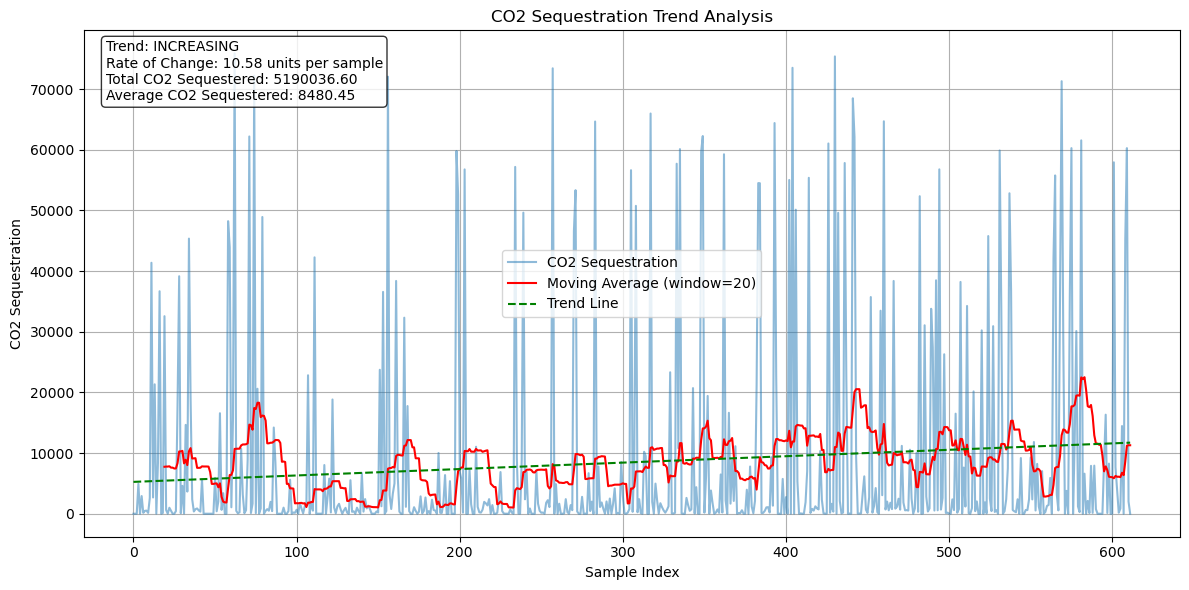


Climate Impact Analysis:
--------------------------------------------------
Climate Impact: INCREASING
Rate of Change: 10.58 units per sample
Total CO2 Sequestered: 5190036.60
Average CO2 Sequestered: 8480.45

Detailed Statistics:
--------------------------------------------------
Maximum CO2 Sequestration: 75908.70
Minimum CO2 Sequestration: 0.00
Standard Deviation: 17190.81

Percentage of Samples with Positive Sequestration: 81.05%


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CO2 sequestration data
df = pd.read_csv('result/CO2_seq.csv')

# Calculate total CO2 sequestration
total_co2 = df['carbon_sequestration'].sum()
average_co2 = df['carbon_sequestration'].mean()

# Calculate trend using moving average
window_size = 20
df['moving_avg'] = df['carbon_sequestration'].rolling(window=window_size).mean()

# Calculate overall trend using linear regression
x = np.arange(len(df))
coefficients = np.polyfit(x, df['carbon_sequestration'], 1)
trend_line = coefficients[0] * x + coefficients[1]

# Determine if climate impact is positive or negative
trend_direction = 'INCREASING' if coefficients[0] > 0 else 'DECREASING'
impact_strength = abs(coefficients[0])

# Create visualization
plt.figure(figsize=(12, 6))
plt.plot(df['carbon_sequestration'], label='CO2 Sequestration', alpha=0.5)
plt.plot(df['moving_avg'], label=f'Moving Average (window={window_size})', color='red')
plt.plot(x, trend_line, '--', label='Trend Line', color='green')

plt.title('CO2 Sequestration Trend Analysis')
plt.xlabel('Sample Index')
plt.ylabel('CO2 Sequestration')
plt.legend()
plt.grid(True)

# Add trend information to plot
text_info = f"Trend: {trend_direction}\n"
text_info += f"Rate of Change: {coefficients[0]:.2f} units per sample\n"
text_info += f"Total CO2 Sequestered: {total_co2:.2f}\n"
text_info += f"Average CO2 Sequestered: {average_co2:.2f}"

plt.text(0.02, 0.98, text_info,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\nClimate Impact Analysis:")
print("-" * 50)
print(f"Climate Impact: {trend_direction}")
print(f"Rate of Change: {coefficients[0]:.2f} units per sample")
print(f"Total CO2 Sequestered: {total_co2:.2f}")
print(f"Average CO2 Sequestered: {average_co2:.2f}")

# Additional insights
print("\nDetailed Statistics:")
print("-" * 50)
print(f"Maximum CO2 Sequestration: {df['carbon_sequestration'].max():.2f}")
print(f"Minimum CO2 Sequestration: {df['carbon_sequestration'].min():.2f}")
print(f"Standard Deviation: {df['carbon_sequestration'].std():.2f}")

# Calculate percentage of samples showing positive sequestration
positive_samples = (df['carbon_sequestration'] > 0).sum()
total_samples = len(df)
positive_percentage = (positive_samples / total_samples) * 100

print(f"\nPercentage of Samples with Positive Sequestration: {positive_percentage:.2f}%")